In [40]:
import keras
import pandas as pd
import numpy as np
import pickle
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from import_and_clean_data import import_and_clean_data
from import_yearly_data import import_yearly_data
from feature_engineering import feature_engineering
from moving_average_graph import moving_average_graph
from class_model import class_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score,precision_score,recall_score,f1_score,accuracy_score,confusion_matrix,precision_recall_curve

In [2]:
%load_ext autoreload
%autoreload 2

# Import and cleaning data

In [ ]:
#Takes 3-4 hours due to the Genius API
weekly_filepath='Hot Stuff.csv'
df=import_and_clean_data(weekly_filepath)

In [ ]:
# with open('0617_pre_engineering.pickle','rb') as read_file:
#     df = pickle.load(read_file)

In [ ]:
year_end_filepath='billboard_lyrics_1964_2015.csv'
df_lyrics, df_genre_summary, df_features=import_yearly_data(year_end_filepath)

# Feature Engineering

In [ ]:
df=feature_engineering(df, df_lyrics, df_genre_summary, df_features)

# Modeling Prep

In [ ]:
#One hot encode categorical columns
df=pd.get_dummies(df,columns=['decade'],drop_first=True)

In [3]:
with open('0617_modeling_data.pickle','rb') as read_file:
    df = pickle.load(read_file)

In [4]:
X=df.drop(columns=['one_hit'])
y=df['one_hit']
X_trainval,X_test,y_trainval,y_test=train_test_split(X, y, test_size=.2, random_state=4, stratify=y)

In [5]:
std=StandardScaler()
X_trainval_scaled=std.fit_transform(X_trainval)
X_test_scaled=std.transform(X_test)

# Dummy Classifier

In [6]:
#Dummy classifier
dc=DummyClassifier(strategy='most_frequent')
print('Dummy Classifier')
class_model(dc,X_trainval,y_trainval);

Dummy Classifier
accuracy_scores_train 0.5216666666666667
f1_scores_train 0.0
roc_auc_scores_train 0.5
recall_scores_train 0.0
precision_scores_train 0.0
accuracy_scores_val 0.5216666666666667
f1_scores_val 0.0
roc_auc_scores_val 0.5
recall_scores_val 0.0
precision_scores_val 0.0


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site

# Random Forest

In [7]:
parameters={'n_estimators':[50,100,200,400],'max_depth':[3,5,8,10]}
rf=RandomForestClassifier()
clf=GridSearchCV(rf,parameters,cv=5,scoring='f1')
clf.fit(X_trainval,y_trainval)
print("RF best parameter",clf.best_params_,"and F1 score",clf.best_score_)

RF best parameter {'max_depth': 10, 'n_estimators': 50} and F1 score 0.6557900517084372


In [8]:
rf = RandomForestClassifier(random_state=4,n_estimators=400,max_depth=6,min_samples_split=5)
print('Random Forest')
class_model(rf,X_trainval,y_trainval);

Random Forest
accuracy_scores_train 0.87375
f1_scores_train 0.868202703851361
roc_auc_scores_train 0.9505200343585818
recall_scores_train 0.8691272625271906
precision_scores_train 0.8678339911982593
accuracy_scores_val 0.6566666666666666
f1_scores_val 0.6333356300198876
roc_auc_scores_val 0.7182930133121096
recall_scores_val 0.6223030155102187
precision_scores_val 0.6475382948010088


In [9]:
top_features=sorted(list(zip(X_trainval.columns,rf.feature_importances_)),key=lambda x:np.abs(x[1]),reverse=True)
top_features

[('genre_score', 0.12784560438045942),
 ('peak_pos_chart_div', 0.07722840410209851),
 ('peak_position', 0.0755109977198675),
 ('duration_ms', 0.04709682740270452),
 ('lyrical_distance', 0.046391861201256705),
 ('pop', 0.04367600357842871),
 ('valence', 0.04205696462587699),
 ('lyric_variety', 0.039968290622014624),
 ('tempo', 0.03882502360729568),
 ('acousticness', 0.03711403790410345),
 ('sentiment', 0.03697167836385008),
 ('loudness', 0.03663586531612808),
 ('Weeks on Chart', 0.03567661601040404),
 ('danceability', 0.032583698778438405),
 ('lyric_difficulty', 0.03211931903422629),
 ('liveness', 0.031653810573931684),
 ('feature_distance', 0.03118251211111678),
 ('speechiness', 0.03094349681470286),
 ('dance', 0.02983892560461502),
 ('instrumentalness', 0.02161465757737796),
 ('hip hop', 0.01607592197554229),
 ('num_entities', 0.01564139435884525),
 ('decade_10s', 0.012947501127819566),
 ('rock', 0.012767708488413264),
 ('r&b', 0.01117934350283736),
 ('country', 0.01034216742787968),


# Logistic Regression

In [10]:
parameters={'C':10**(np.linspace(-4,0,50))}
lr=LogisticRegression(solver='liblinear',penalty='l1')
clf=GridSearchCV(lr,parameters,cv=5,scoring='f1')
std=StandardScaler()
X_trainval_scaled=std.fit_transform(X_trainval)
clf.fit(X_trainval_scaled,y_trainval)
print("Logistic Regression best parameter",clf.best_params_,"and F1 score",clf.best_score_)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-pac

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-pac

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/opt/anaconda3/envs/metis/lib/python3.7/site-pac

Logistic Regression best parameter {'C': 0.05963623316594643} and F1 score 0.6537428589609098


/opt/anaconda3/envs/metis/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [11]:
lr_l1=LogisticRegression(solver='liblinear',C=.07,penalty='l1')
print('Logistic Regression Lasso')
lr_l1=class_model(lr_l1,X_trainval,y_trainval,scaling=1,threshold=1);

Logistic Regression Lasso
threshold_val 0.4084561772164525
f1_threshold_val 0.7107733039970664
accuracy_scores_train 0.6785416666666666
f1_scores_train 0.6730057940467734
roc_auc_scores_train 0.7473638734963691
recall_scores_train 0.692212102732918
precision_scores_train 0.6549712911041404
accuracy_scores_val 0.6575
f1_scores_val 0.6524585768372969
roc_auc_scores_val 0.7271619104039584
recall_scores_val 0.6749421406818261
precision_scores_val 0.6337778041167872


/Users/elarson649/Desktop/Metis/Project-5/class_model.py:120: RuntimeWarning: invalid value encountered in true_divide
  fbeta_curve = (2 * precision_curve[1:] * recall_curve[1:]) / (precision_curve[1:] + recall_curve[1:])


In [12]:
sorted(list(zip(X_trainval.columns,lr_l1.coef_[0])),key=lambda x:np.abs(x[1]),reverse=True)

[('genre_score', -0.2751902737636191),
 ('hip hop', -0.2634923181461743),
 ('country', -0.2157386138402596),
 ('decade_10s', 0.20246885750215862),
 ('dance', -0.18845632893412892),
 ('peak_pos_chart_div', -0.18413898017175254),
 ('peak_position', 0.17970978673698781),
 ('pop', -0.17289409257007268),
 ('rock', -0.13631981739688315),
 ('Featured_Performer', 0.12164044141463862),
 ('decade_80s', -0.09412014044019701),
 ('lyrical_distance', -0.09369775803116012),
 ('decade_90s', -0.05641730339818399),
 ('foreign_language', -0.04243368879850624),
 ('r&b', -0.02197581431237162),
 ('lyric_difficulty', -0.021420956801619873),
 ('danceability', 0.001182003323918933),
 ('tempo', -0.0006057240218944203),
 ('liveness', -2.7164986507983433e-05),
 ('Weeks on Chart', 0.0),
 ('loudness', 0.0),
 ('speechiness', 0.0),
 ('acousticness', 0.0),
 ('instrumentalness', 0.0),
 ('valence', 0.0),
 ('duration_ms', 0.0),
 ('hit_writers', 0.0),
 ('hit_producers', 0.0),
 ('mode_1', 0.0),
 ('lyric_variety', 0.0),
 ('

In [13]:
parameters={'C':10**(np.linspace(-4,0,50))}
lr=LogisticRegression(solver='liblinear')
clf=GridSearchCV(lr,parameters,cv=5,scoring='f1')
std=StandardScaler()
X_trainval_scaled=std.fit_transform(X_trainval)
clf.fit(X_trainval_scaled,y_trainval)
print("Logistic Regression best parameter",clf.best_params_,"and F1 score",clf.best_score_)

Logistic Regression best parameter {'C': 0.0024420530945486497} and F1 score 0.6549299380624567


In [14]:
lr_l2=LogisticRegression(solver='liblinear',C=.02)
print('Logistic Regression Ridge')
class_model(lr_l2,X_trainval,y_trainval,scaling=1,threshold=1);

Logistic Regression Ridge
threshold_val 0.35604094603859215
f1_threshold_val 0.707881602085429
accuracy_scores_train 0.6852083333333334
f1_scores_train 0.6730794291226587
roc_auc_scores_train 0.7560725632115982
recall_scores_train 0.677896979625496
precision_scores_train 0.6685843092109778
accuracy_scores_val 0.665
f1_scores_val 0.6530030117029846
roc_auc_scores_val 0.7299710583950573
recall_scores_val 0.6620113128205218
precision_scores_val 0.6453526564396543


/Users/elarson649/Desktop/Metis/Project-5/class_model.py:120: RuntimeWarning: invalid value encountered in true_divide
  fbeta_curve = (2 * precision_curve[1:] * recall_curve[1:]) / (precision_curve[1:] + recall_curve[1:])


In [15]:
sorted(list(zip(X_trainval.columns,lr_l2.coef_[0])),key=lambda x:np.abs(x[1]),reverse=True)

[('hip hop', -0.31051812578418125),
 ('genre_score', -0.2744888282212206),
 ('country', -0.24569236801089553),
 ('peak_pos_chart_div', -0.22263560415485315),
 ('pop', -0.2192316079515337),
 ('dance', -0.21250326627979768),
 ('peak_position', 0.19375872709026185),
 ('decade_10s', 0.1731458178796985),
 ('rock', -0.16046261778793217),
 ('Featured_Performer', 0.1438621408493276),
 ('decade_80s', -0.1408228472479197),
 ('lyrical_distance', -0.13390723587827694),
 ('decade_90s', -0.11747016983801589),
 ('lyric_difficulty', -0.0993776891743674),
 ('r&b', -0.0927894169378361),
 ('foreign_language', -0.08637368733587945),
 ('num_entities', -0.08558918061252269),
 ('danceability', 0.07890509155470504),
 ('valence', -0.06021797730261019),
 ('lyric_variety', -0.057863982827012356),
 ('liveness', -0.05365890566087578),
 ('tempo', -0.04636009707753997),
 ('acousticness', 0.04403359141084599),
 ('sentiment', -0.04331698204916694),
 ('speechiness', 0.041315968319679604),
 ('hit_writers', -0.0303175584

# SVM

In [16]:
#SVM- Logistic Regression is better, so let's just go with that
parameters={'C':10**(np.linspace(-4,-1,20))}
lin_svm=LinearSVC(dual=False)
clf=GridSearchCV(lin_svm,parameters,cv=5,scoring='f1')
X_trainval_scaled=std.fit_transform(X_trainval)
clf.fit(X_trainval_scaled,y_trainval)
print("Linear SVM best parameter",clf.best_params_,"and F1 score",clf.best_score_)

Linear SVM best parameter {'C': 0.00029763514416313193} and F1 score 0.6549436302993615


In [17]:
lin_svm=LinearSVC(dual=False,C=.0015)
print('Linear SVM')
class_model(lin_svm,X_trainval,y_trainval,scaling=1);

Linear SVM
accuracy_scores_train 0.6829166666666667
f1_scores_train 0.6703083877568187
roc_auc_scores_train 0.7538182215824587
recall_scores_train 0.6744152994174356
precision_scores_train 0.6665758540993101
accuracy_scores_val 0.6675
f1_scores_val 0.6552103962882382
roc_auc_scores_val 0.7292624582397778
recall_scores_val 0.664942773376783
precision_scores_val 0.647019182164793


# KNN

In [18]:
knn=KNeighborsClassifier(n_neighbors=5)
print('KNN')
class_model(knn,X_trainval,y_trainval,scaling=1);

KNN
accuracy_scores_train 0.7627083333333333
f1_scores_train 0.7574652423023914
roc_auc_scores_train 0.8372660643118556
recall_scores_train 0.7747202956431923
precision_scores_train 0.7411815707507575
accuracy_scores_val 0.6408333333333334
f1_scores_val 0.6355978757166713
roc_auc_scores_val 0.6865621426952069
recall_scores_val 0.6565053216295522
precision_scores_val 0.6179554064263733


# XGBoost

In [19]:
print('XGBoost')
gbm = xgb.XGBClassifier(
    n_estimators=30000,  #arbitrary large number
    max_depth=3,
    objective="binary:logistic",
    learning_rate=.05,
    subsample=.7,
    min_child_weight=3,
    colsample_bytree=.6,
    n_jobs=-1,
    reg_alpha=.1,
    reg_lambda=1.1,
    random_state=4)

class_model(gbm,X_trainval,y_trainval,early_stopping_rounds=50);

XGBoost
accuracy_scores_train 0.8152083333333333
f1_scores_train 0.8064572658970077
roc_auc_scores_train 0.8987954752830941
recall_scores_train 0.8038842022879658
precision_scores_train 0.8093158453684269
accuracy_scores_val 0.6608333333333333
f1_scores_val 0.6410379561184498
roc_auc_scores_val 0.7160918130545204
recall_scores_val 0.6364765168959379
precision_scores_val 0.6464765274250347


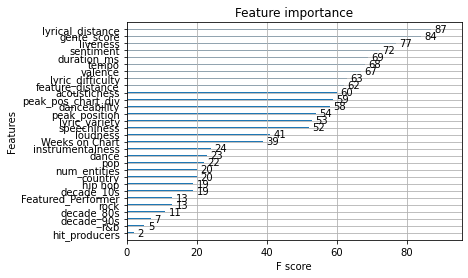

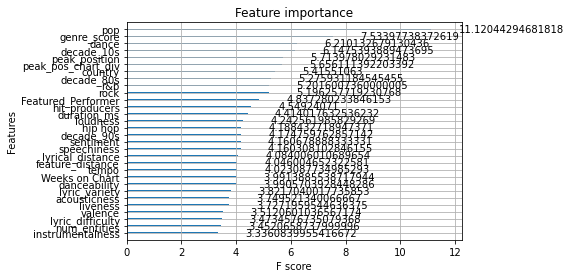

In [20]:
xgb.plot_importance(gbm)
xgb.plot_importance(gbm, importance_type='gain')

# Keras

In [21]:
keras_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=X_trainval_scaled.shape[1:]),
    keras.layers.Dense(units=10, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=5, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(units=1, activation="sigmoid"),
])
callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=.5, patience=3, verbose=0),]
compiler='model_copy.compile(keras.optimizers.adam(lr=0.001), loss="binary_crossentropy", metrics=["acc"])'

Instructions for updating:
Colocations handled automatically by placer.


In [22]:
keras_model=class_model(keras_model, X_trainval, y_trainval, scaling=1, callbacks=callbacks, epochs=1000, threshold=1, compiler=compiler)

Instructions for updating:
Use tf.cast instead.
Restoring model weights from the end of the best epoch
Epoch 00054: early stopping


/Users/elarson649/Desktop/Metis/Project-5/class_model.py:120: RuntimeWarning: invalid value encountered in true_divide
  fbeta_curve = (2 * precision_curve[1:] * recall_curve[1:]) / (precision_curve[1:] + recall_curve[1:])


Restoring model weights from the end of the best epoch
Epoch 00056: early stopping
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping
Restoring model weights from the end of the best epoch
Epoch 00058: early stopping
Restoring model weights from the end of the best epoch
Epoch 00089: early stopping
threshold_val 0.35900164
f1_threshold_val 0.7124211654346267
accuracy_scores_train 0.7166666666666666
f1_scores_train 0.7035240453887285
roc_auc_scores_train 0.7882427694416158
recall_scores_train 0.7035706517411588
precision_scores_train 0.704136588353059
accuracy_scores_val 0.6691666666666667
f1_scores_val 0.655043774271065
roc_auc_scores_val 0.7398601459576372
recall_scores_val 0.660213442137308
precision_scores_val 0.6514136598999796


# Winning Model

In [23]:
keras_model = keras.Sequential([
    keras.layers.InputLayer(input_shape=X_trainval_scaled.shape[1:]),
    keras.layers.Dense(units=10, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(0.1)),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=5, activation="relu",
                       kernel_regularizer=keras.regularizers.l2(0.001)),
    keras.layers.Dense(units=1, activation="sigmoid"),
])
callbacks=[keras.callbacks.EarlyStopping(monitor='loss', patience=8, verbose=1, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=.5, patience=3, verbose=0),]
keras_model.compile(keras.optimizers.adam(lr=0.001), loss="binary_crossentropy", metrics=["acc"])

Restoring model weights from the end of the best epoch
Epoch 00045: early stopping


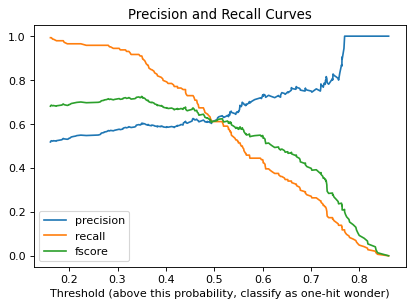

In [24]:
# Let's create a precision-recall curve and use those scores to calculate F-beta
keras_model.fit(X_trainval_scaled, y_trainval, epochs=1000, callbacks=callbacks, verbose=0)
precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, keras_model.predict(X_test_scaled))
fscore=(2*precision_curve[1:]*recall_curve[1:])/(precision_curve[1:]+recall_curve[1:])
plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.plot(threshold_curve,fscore,label='fscore')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, classify as one-hit wonder)');
plt.title('Precision and Recall Curves');
plt.savefig('precisionrecall.png',bbox_inches='tight')

In [25]:
#Threshold comes from validation testing
threshold_val=0.358
predict_proba=keras_model.predict(X_test_scaled)
predict_with_thres=(predict_proba>threshold_val)*1
print('Final test accuracy:',accuracy_score(y_test,predict_with_thres))
print('Final test Fscore:',f1_score(y_test,predict_with_thres))  
print('Final test ROC AUC:',roc_auc_score(y_test,predict_proba))
print('Final test recall:', recall_score(y_test,predict_with_thres))
print('Final test precision:',precision_score(y_test,predict_with_thres))

Final test accuracy: 0.66
Final test Fscore: 0.7134831460674157
Final test ROC AUC: 0.72872150997151
Final test recall: 0.8819444444444444
Final test precision: 0.5990566037735849


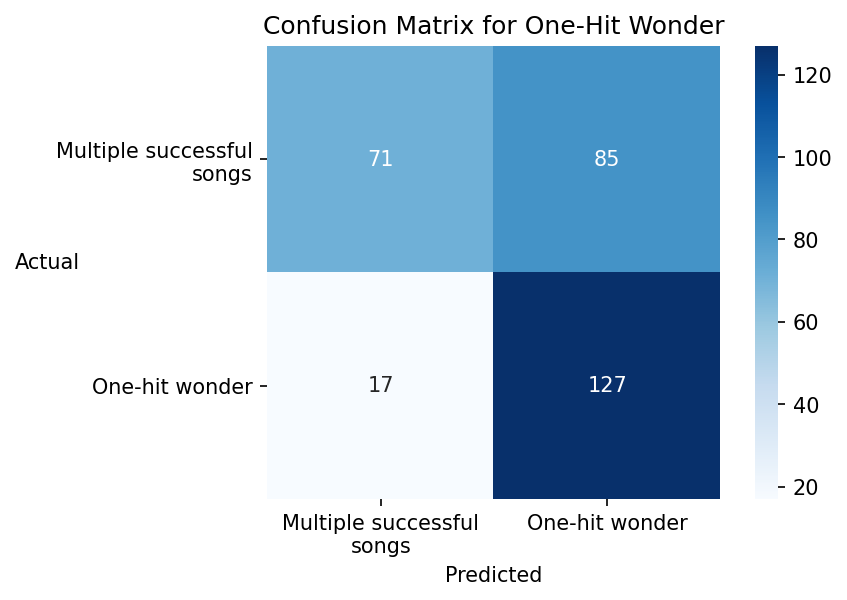

In [26]:
# Print confusion matrix for logistic regression
lr_confusion = confusion_matrix(y_test,predict_with_thres)
plt.figure(dpi=150)
sns.heatmap(lr_confusion,cmap='Blues', annot=True, square=True,
           xticklabels=['Multiple successful\nsongs','One-hit wonder'],
           yticklabels=['Multiple successful\nsongs','One-hit wonder'],fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual',rotation=0)
plt.yticks(rotation=0) 
plt.title('Confusion Matrix for One-Hit Wonder')
plt.savefig('confusionmatrix.png',bbox_inches='tight')

# EDA

In [ ]:
df_first['one_hit']=df_first['total_songs_on_chart'].where(df_first['total_songs_on_chart']==1,0)
test=df_first[['one_hit','genres']]
test['num_genres']=test['genres'].apply(lambda x:len(x))
test.groupby('one_hit')['num_genres'].mean()

In [ ]:
category='mode_1'
(df_model.groupby([category,'one_hit'])['one_hit'].count())/(df_model.groupby([category])[category].count())

In [ ]:
category='Featured_Performer'
(df_model.groupby([category,'one_hit'])['one_hit'].count())/(df_model.groupby([category])[category].count())

In [ ]:
category='lyric_outlier'
(df_model.groupby([category,'one_hit'])['one_hit'].count())/(df_model.groupby([category])[category].count())

In [ ]:
df_model.groupby('one_hit')['genre_score'].mean()

In [ ]:
df_model.groupby('one_hit')['num_entities'].mean()

In [ ]:
df_model.groupby('one_hit')['lyrical_distance'].mean()

In [ ]:
df_model.groupby('one_hit')['lyric_variety'].mean()

In [ ]:
df_model.groupby('one_hit')['foreign_language'].mean()

In [ ]:
df_model.groupby('one_hit')['sentiment'].mean()

In [ ]:
df_model.groupby('one_hit')['hit_producers'].mean()

In [ ]:
df_model.groupby('one_hit')['hit_writers'].mean()

In [ ]:
df_model.groupby('one_hit')['Weeks on Chart'].mean()

In [ ]:
corr=X.corr()
np.fill_diagonal(corr.values, np.nan)
high_corr=[]
for column in corr:
    for number,row in enumerate(corr[column]):
        if row > .5:
            high_corr.append(((column,corr.index[number]),row))
print(high_corr)

# P-values

In [27]:
import numpy as np
import statsmodels.api as sm

In [28]:
n=X_trainval_scaled.shape[0]
X0 = np.ones((n,1))
X_statsmodel = np.hstack((X0, X_trainval_scaled))

In [29]:
features=list(X_trainval.columns)
features.insert(0,'intercept')

In [30]:
model = sm.Logit(y_trainval, X_statsmodel)
result = model.fit_regularized(alpha=1,L1_wt=1)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.5887137818650444
            Iterations: 63
            Function evaluations: 64
            Gradient evaluations: 63


In [31]:
result.summary(xname=features)

/opt/anaconda3/envs/metis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                one_hit   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1167
Method:                           MLE   Df Model:                           32
Date:                Sat, 20 Jun 2020   Pseudo R-squ.:                  0.1553
Time:                        14:47:07   Log-Likelihood:                -701.67
converged:                       True   LL-Null:                       -830.65
Covariance Type:            nonrobust   LLR p-value:                 3.804e-37
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             -0.1124      0.065     -1.735      0.083      -0.239       0.015
peak_position          0.2514      0.085      2.964      0.003       0.085       0.418
Weeks on Chart              0        nan        nan        nan         nan         nan
Featured_Performer     0.1576      0.075      2.105      0.035       0.011       0.304
danceability           0.1648      0.090      1.835      0.067      -0.011       0.341
loudness               0.0211      0.082      0.256      0.798      -0.140       0.183
speechiness            0.1055      0.097      1.084      0.278      -0.085       0.296
acousticness           0.0528      0.075      0.708      0.479      -0.093       0.199
instrumentalness       0.0597      0.075      0.793      0.428      -0.088       0.207
liveness              -0.0582      0.069     -0.841      0.400      -0.194       0.077
valence               -0.0831      0.081     -1.031      0.302      -0.241       0.075
tempo                 -0.0028      0.068     -0.041      0.968      -0.136       0.130
duration_ms           -0.0185      0.074     -0.248      0.804      -0.164       0.127
hit_writers           -0.0226      0.077     -0.295      0.768      -0.173       0.128
hit_producers          0.0444      0.072      0.614      0.539      -0.097       0.186
country               -0.4147      0.077     -5.387      0.000      -0.566      -0.264
hip hop               -0.5255      0.106     -4.935      0.000      -0.734      -0.317
pop                   -0.1596      0.089     -1.788      0.074      -0.335       0.015
r&b                   -0.0713      0.080     -0.888      0.375      -0.229       0.086
rock                  -0.1632      0.089     -1.838      0.066      -0.337       0.011
mode_1                -0.0609      0.068     -0.898      0.369      -0.194       0.072
lyric_variety         -0.0159      0.077     -0.206      0.837      -0.168       0.136
foreign_language      -0.1161      0.074     -1.579      0.114      -0.260       0.028
lyric_difficulty      -0.1773      0.119     -1.493      0.135      -0.410       0.055
num_entities          -0.1239      0.087     -1.426      0.154      -0.294       0.046
sentiment             -0.0212      0.067     -0.316      0.752      -0.152       0.110
lyrical_distance      -0.1661      0.068     -2.450      0.014      -0.299      -0.033
genre_score           -0.3794      0.096     -3.945      0.000      -0.568      -0.191
feature_distance      -0.0110      0.087     -0.126      0.900      -0.182       0.160
peak_pos_chart_div    -0.3067      0.094     -3.261      0.001      -0.491      -0.122
dance                 -0.2932      0.080     -3.670      0.000      -0.450      -0.137
decade_10s             0.2256      0.083      2.732      0.006       0.064       0.387
decade_80s            -0.2282      0.106     -2.148      0.032      -0.436      -0.020
decade_90s            -0.1698      0.089     -1.900      0.057      -0.345       0.005
======================

# Feature importance

In [32]:
from sklearn.feature_selection import RFE

In [33]:
fit_model=LogisticRegression(solver='liblinear',C=.07,penalty='l1')
rfe = RFE(fit_model, 1)
fit = rfe.fit(X_trainval_scaled,y_trainval)

In [34]:
X_trainval.columns[np.argsort(fit.ranking_)]

Index(['genre_score', 'peak_position', 'decade_10s', 'country', 'dance',
       'peak_pos_chart_div', 'hip hop', 'rock', 'Featured_Performer',
       'decade_80s', 'pop', 'lyrical_distance', 'danceability', 'decade_90s',
       'speechiness', 'foreign_language', 'lyric_difficulty', 'r&b',
       'liveness', 'lyric_variety', 'hit_producers', 'instrumentalness',
       'acousticness', 'loudness', 'num_entities', 'valence', 'sentiment',
       'feature_distance', 'Weeks on Chart', 'tempo', 'mode_1', 'hit_writers',
       'duration_ms'],
      dtype='object')

# Graphs

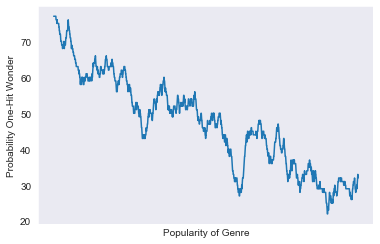

In [35]:
moving_average_graph(df, 'genre_score', 100, x_label='Popularity of Genre', y_label='Probability One-Hit Wonder')

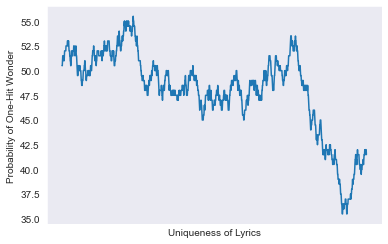

In [36]:
moving_average_graph(df, 'lyrical_distance', 200, x_label='Uniqueness of Lyrics', y_label='Probability of One-Hit Wonder')

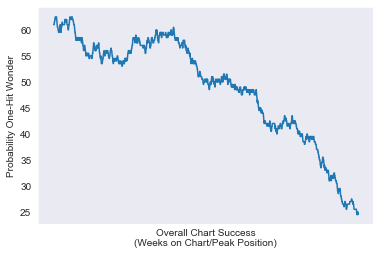

In [37]:
moving_average_graph(df, 'peak_pos_chart_div', 200, x_label='Overall Chart Success\n(Weeks on Chart/Peak Position)', y_label='Probability One-Hit Wonder')